## Goal... test training schemes
Test: Using $W_{\mathrm{res}}\in\mathbb{R}^{N\times N}$ we take $N$ steps, predicting at each step and getting the loss $\mathcal{L}$, before backprop. This is motivated by work in Chaos paper. The max reservoir memory is $t-N$ time-steps to predict the next step $t+1$.

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import nn, Tensor, optim
from torch.nn.parameter import Parameter
import pdb 
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import optim
DEV = 'cuda:6'
DTYPE = torch.float32 

In [3]:
K = 1
N = 3
L = 1

In [4]:

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        self.a_list = []
        self.g_list = []
        
    def forward(self, x, z):
        self.a.register_hook(lambda x: self.a_list.append(x.data))
        self.g.register_hook(lambda x: self.g_list.append(x.data))
        return (1-self.a)*x + self.a*self.g*torch.tanh(x+z)
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)
        self.sr_list = []

    def forward(self, hidden, ut):
        self.D.register_hook(lambda x: self.sr_list.append(x.data))
        z = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,z)
        output = self.Rout(torch.cat((ht1,ut),1))
        return ht1, output

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q), torch.real(D), torch.real(torch.transpose(Q,0,1))
    
    def clearList(self):
        self.a_list = []
        self.g_list = []
        #self.sr_list = []


esn = SymESN(K,N,L,1.0,.6)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=3, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=4, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


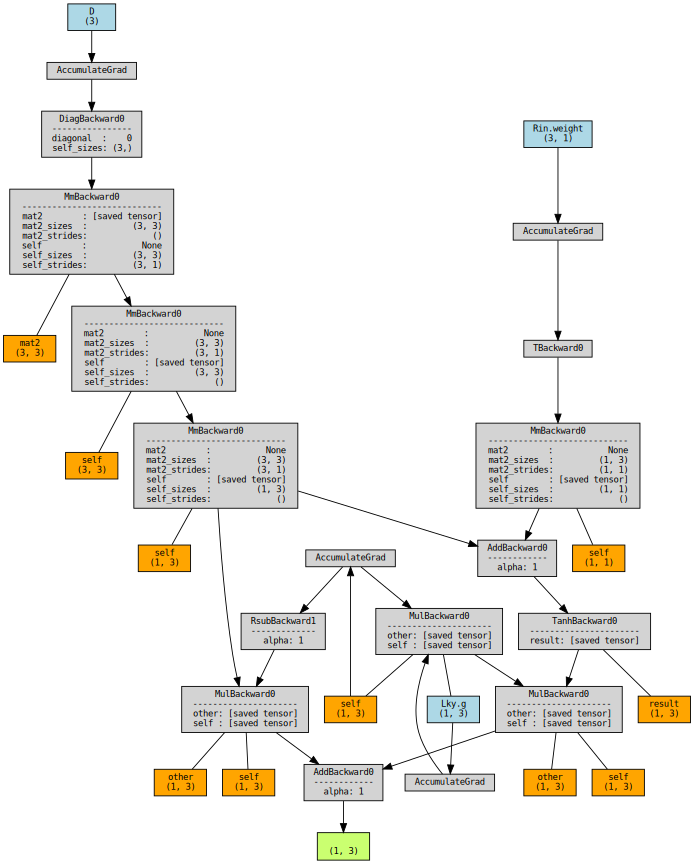

In [5]:
ut = torch.Tensor([[1]])
xt = esn.packState()
xt1, yhat = esn(xt,ut)
make_dot(xt1, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

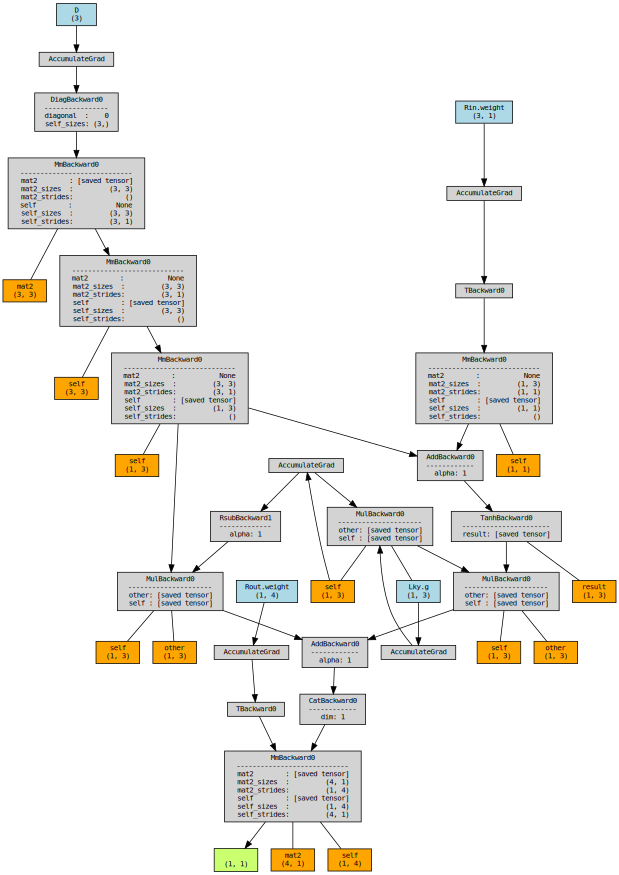

In [6]:
make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [7]:
FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)
Tl = N
muX = np.mean(states[:,0])
signal = states[:Tl,0]-muX

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.05)

Eigenvals tensor([0.4787, 0.9596, 0.2343])
Epoch: 0


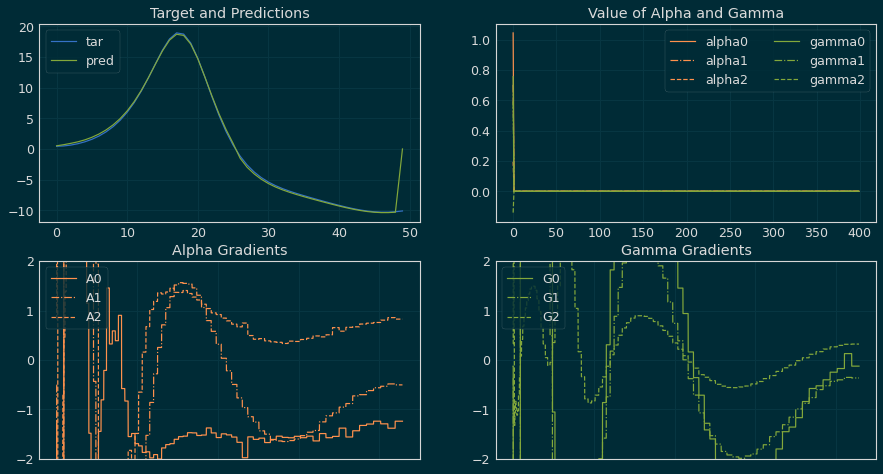

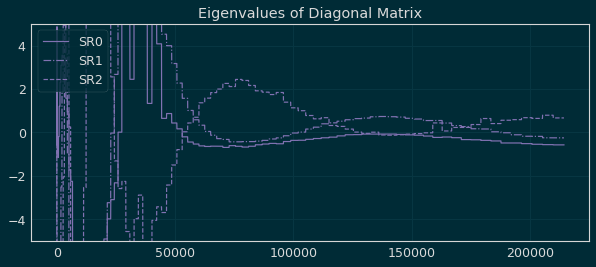

Eigenvals tensor([0.4836, 0.9588, 0.2312])
Eigenvals tensor([0.4889, 0.9582, 0.2280])
Eigenvals tensor([0.4944, 0.9577, 0.2246])
Eigenvals tensor([0.5003, 0.9575, 0.2210])
Eigenvals tensor([0.5065, 0.9574, 0.2173])
Eigenvals tensor([0.5131, 0.9575, 0.2136])
Eigenvals tensor([0.5200, 0.9577, 0.2098])
Eigenvals tensor([0.5272, 0.9579, 0.2061])
Eigenvals tensor([0.5348, 0.9583, 0.2023])
Eigenvals tensor([0.5427, 0.9586, 0.1985])
Epoch: 10


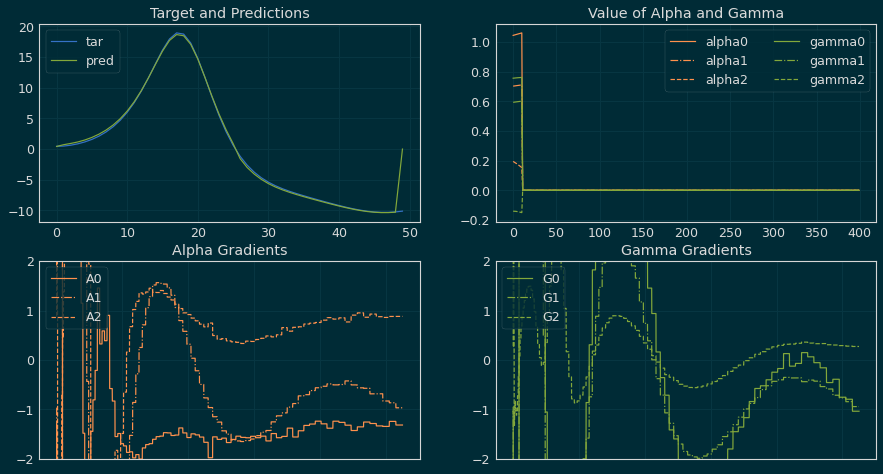

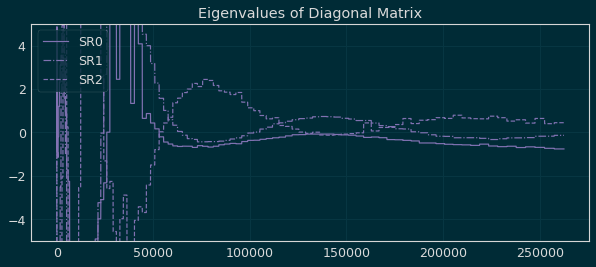

Eigenvals tensor([0.5509, 0.9591, 0.1948])
Eigenvals tensor([0.5594, 0.9595, 0.1909])
Eigenvals tensor([0.5684, 0.9599, 0.1873])
Eigenvals tensor([0.5777, 0.9604, 0.1836])
Eigenvals tensor([0.5874, 0.9609, 0.1800])
Eigenvals tensor([0.5976, 0.9613, 0.1766])
Eigenvals tensor([0.6084, 0.9618, 0.1733])
Eigenvals tensor([0.6200, 0.9623, 0.1703])
Eigenvals tensor([0.6323, 0.9627, 0.1674])
Eigenvals tensor([0.6455, 0.9633, 0.1647])
Epoch: 20


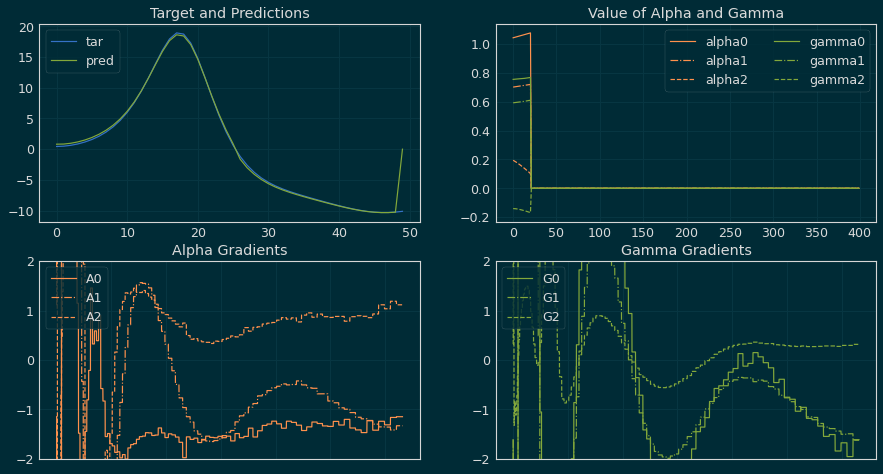

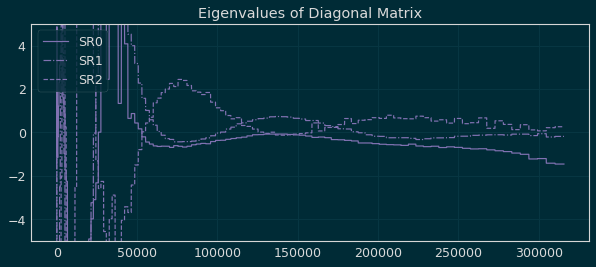

Eigenvals tensor([0.6598, 0.9638, 0.1620])
Eigenvals tensor([0.6743, 0.9643, 0.1596])
Eigenvals tensor([0.6902, 0.9649, 0.1575])
Eigenvals tensor([0.7080, 0.9656, 0.1553])
Eigenvals tensor([0.7281, 0.9665, 0.1535])
Eigenvals tensor([0.7502, 0.9674, 0.1520])
Eigenvals tensor([0.7759, 0.9687, 0.1508])
Eigenvals tensor([0.8059, 0.9703, 0.1501])
Eigenvals tensor([0.8425, 0.9723, 0.1501])
Eigenvals tensor([0.8796, 0.9741, 0.1508])
Epoch: 30


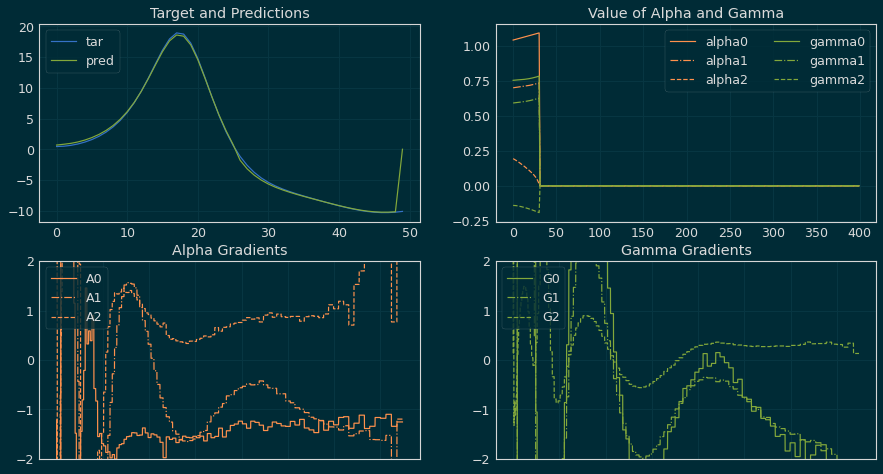

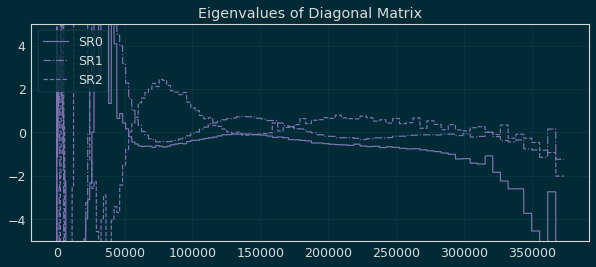

Eigenvals tensor([0.9277, 0.9764, 0.1530])
Eigenvals tensor([0.9757, 0.9780, 0.1564])
Eigenvals tensor([1.0424, 0.9807, 0.1642])
Eigenvals tensor([1.1180, 0.9925, 0.1817])
Eigenvals tensor([1.0656, 0.9405, 0.1299])
Eigenvals tensor([1.0195, 0.8946, 0.0847])
Eigenvals tensor([0.9783, 0.8538, 0.0443])
Eigenvals tensor([0.9412, 0.8172, 0.0078])
Eigenvals tensor([ 0.9077,  0.7845, -0.0253])
Eigenvals tensor([ 0.8776,  0.7551, -0.0553])
Epoch: 40


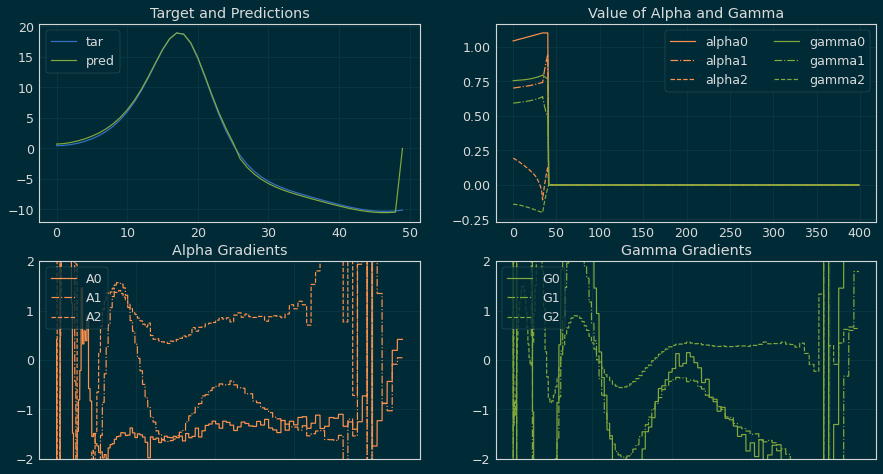

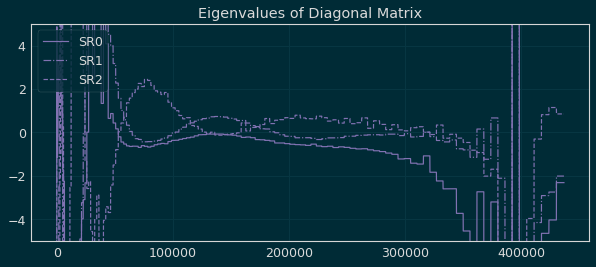

Eigenvals tensor([ 0.8504,  0.7288, -0.0825])
Eigenvals tensor([ 0.8258,  0.7052, -0.1072])
Eigenvals tensor([ 0.8036,  0.6839, -0.1297])
Eigenvals tensor([ 0.7836,  0.6648, -0.1500])
Eigenvals tensor([ 0.7655,  0.6475, -0.1685])
Eigenvals tensor([ 0.7492,  0.6320, -0.1852])
Eigenvals tensor([ 0.7345,  0.6180, -0.2004])
Eigenvals tensor([ 0.7211,  0.6053, -0.2141])
Eigenvals tensor([ 0.7091,  0.5939, -0.2266])
Eigenvals tensor([ 0.6982,  0.5835, -0.2379])
Epoch: 50


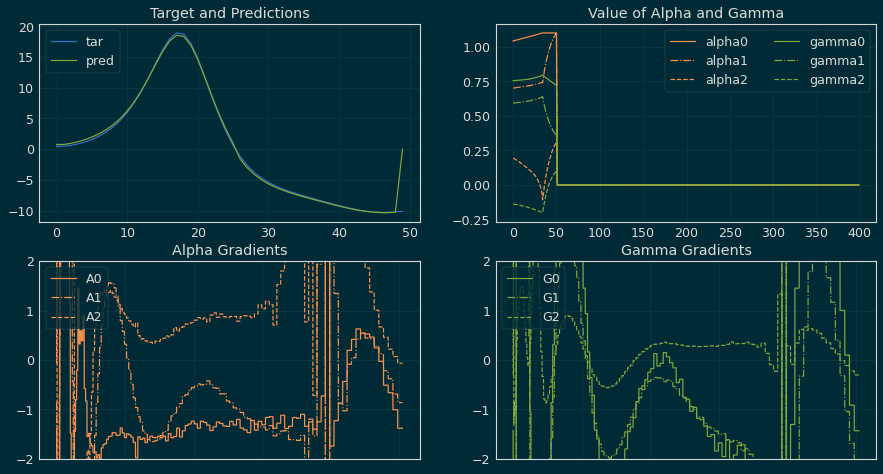

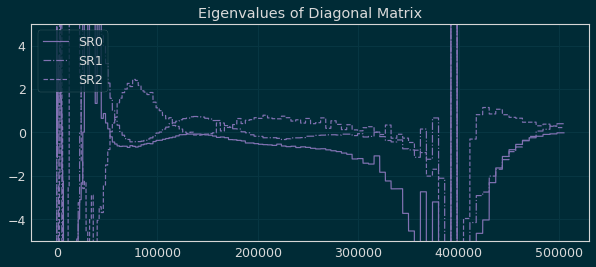

Eigenvals tensor([ 0.6884,  0.5741, -0.2481])
Eigenvals tensor([ 0.6795,  0.5655, -0.2574])
Eigenvals tensor([ 0.6715,  0.5578, -0.2657])
Eigenvals tensor([ 0.6643,  0.5507, -0.2734])
Eigenvals tensor([ 0.6577,  0.5442, -0.2803])
Eigenvals tensor([ 0.6518,  0.5384, -0.2866])
Eigenvals tensor([ 0.6465,  0.5330, -0.2923])
Eigenvals tensor([ 0.6416,  0.5281, -0.2975])
Eigenvals tensor([ 0.6373,  0.5236, -0.3022])
Eigenvals tensor([ 0.6333,  0.5195, -0.3065])
Epoch: 60


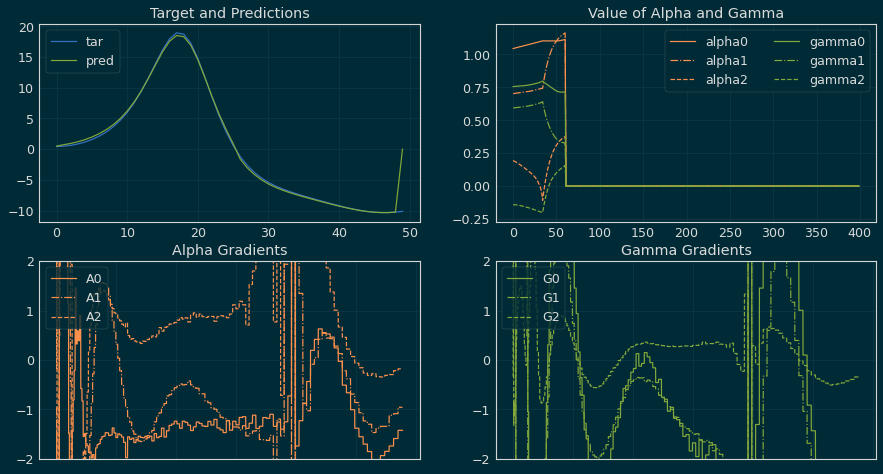

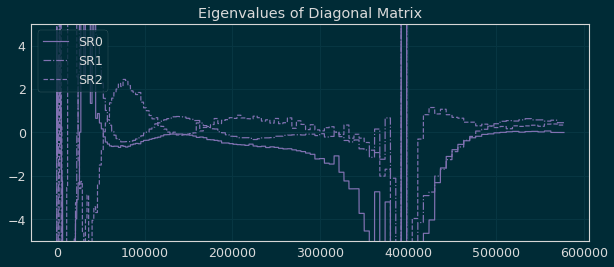

Eigenvals tensor([ 0.6298,  0.5157, -0.3105])
Eigenvals tensor([ 0.6266,  0.5123, -0.3141])
Eigenvals tensor([ 0.6237,  0.5092, -0.3174])
Eigenvals tensor([ 0.6211,  0.5063, -0.3204])
Eigenvals tensor([ 0.6187,  0.5037, -0.3232])
Eigenvals tensor([ 0.6166,  0.5014, -0.3257])
Eigenvals tensor([ 0.6146,  0.4992, -0.3280])
Eigenvals tensor([ 0.6129,  0.4972, -0.3302])
Eigenvals tensor([ 0.6113,  0.4954, -0.3322])
Eigenvals tensor([ 0.6099,  0.4938, -0.3340])
Epoch: 70


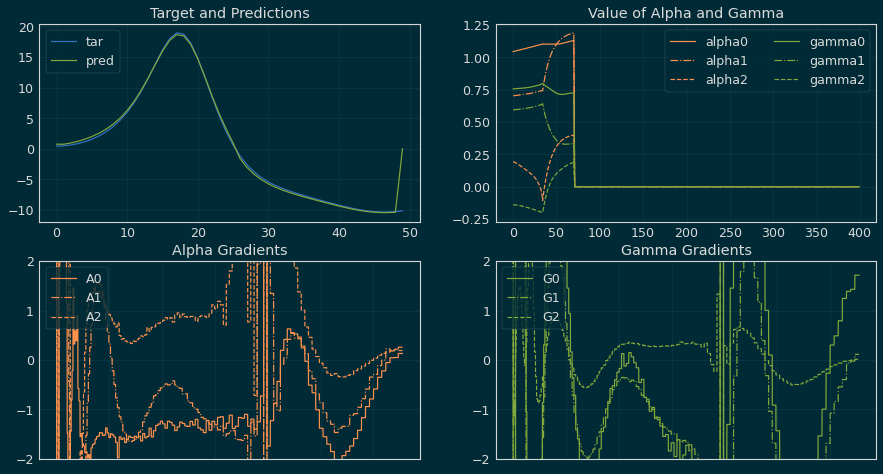

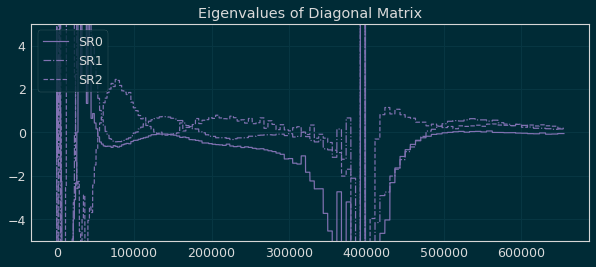

Eigenvals tensor([ 0.6086,  0.4923, -0.3356])
Eigenvals tensor([ 0.6075,  0.4909, -0.3372])
Eigenvals tensor([ 0.6064,  0.4896, -0.3386])
Eigenvals tensor([ 0.6055,  0.4884, -0.3399])
Eigenvals tensor([ 0.6047,  0.4874, -0.3411])
Eigenvals tensor([ 0.6039,  0.4864, -0.3423])
Eigenvals tensor([ 0.6032,  0.4854, -0.3434])
Eigenvals tensor([ 0.6026,  0.4845, -0.3444])
Eigenvals tensor([ 0.6020,  0.4837, -0.3454])
Eigenvals tensor([ 0.6015,  0.4829, -0.3463])
Epoch: 80


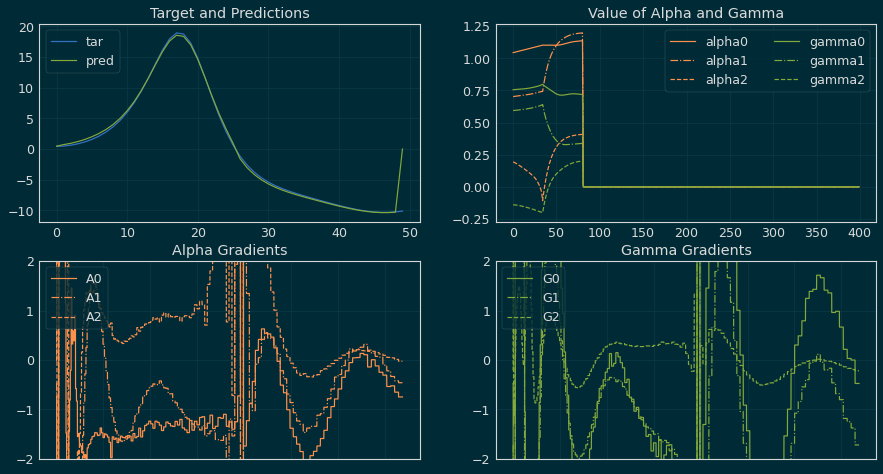

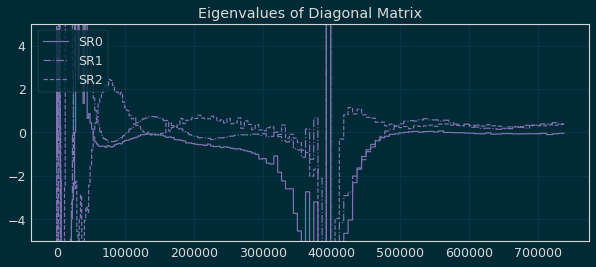

Eigenvals tensor([ 0.6011,  0.4821, -0.3471])
Eigenvals tensor([ 0.6007,  0.4814, -0.3480])
Eigenvals tensor([ 0.6003,  0.4806, -0.3488])
Eigenvals tensor([ 0.6000,  0.4799, -0.3496])
Eigenvals tensor([ 0.5997,  0.4793, -0.3503])
Eigenvals tensor([ 0.5994,  0.4786, -0.3511])
Eigenvals tensor([ 0.5992,  0.4779, -0.3518])
Eigenvals tensor([ 0.5989,  0.4773, -0.3525])
Eigenvals tensor([ 0.5987,  0.4767, -0.3532])
Eigenvals tensor([ 0.5986,  0.4760, -0.3539])
Epoch: 90


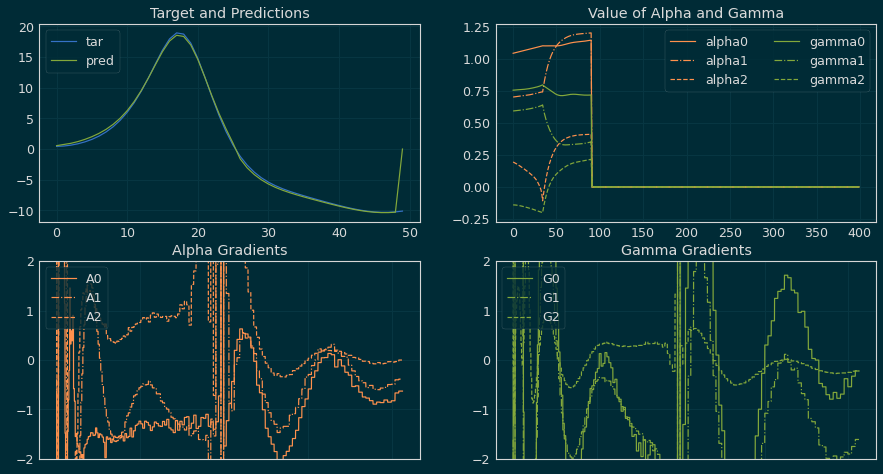

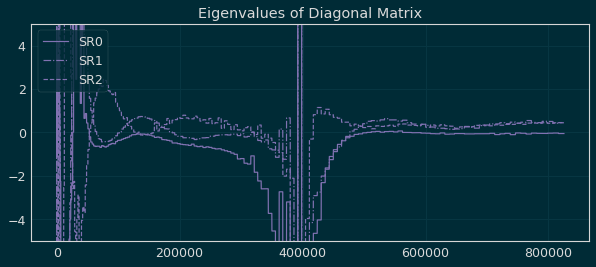

Eigenvals tensor([ 0.5984,  0.4754, -0.3546])
Eigenvals tensor([ 0.5983,  0.4748, -0.3553])
Eigenvals tensor([ 0.5981,  0.4743, -0.3559])
Eigenvals tensor([ 0.5980,  0.4737, -0.3566])
Eigenvals tensor([ 0.5979,  0.4732, -0.3572])
Eigenvals tensor([ 0.5978,  0.4726, -0.3579])


In [ ]:
EPOCHS = 400
alphas = np.zeros((EPOCHS,3))
gammas = np.zeros((EPOCHS,3))
for ep in range(400):
    preds = np.zeros(Tl)
    eigs = np.zeros((Tl,3))
    xt = esn.packState()
    loss = 0.
    optimizer.zero_grad()
    for i in range(TRAIN):
        for j in range(i,i+N):  # Go N steps and make the i+N+1 prediction
            ut = torch.Tensor([[signal[i]]])
            y = torch.Tensor([[signal[i+1]]])
            xt1, yhat = esn(xt,ut)
            loss += criterion(yhat,y)
            preds[i] = yhat.detach().numpy()[0,0]
            eigs[i] = esn.D.data[:]
            xt = xt1
        loss.backward()
        # Deal with plotting later
        #alphas[ep] = esn.Lky.a.data[:]
        #gammas[ep] = esn.Lky.g.data[:]
        #Agrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.a_list])
        #Ggrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.g_list])
        #SRgrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.sr_list])
        #print(f'Eigenvals {esn.D.data}')
        optimizer.step()
        esn.clearList()
    """
    if(ep%10==0):
        print(f'Epoch: {ep}')
        target = signal[:Tl]
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(221)
        ax1.set_title('Target and Predictions')
        ax1.plot(target, label='tar')
        ax1.plot(preds, label='pred')
        ax1.legend(loc='upper left')

        ax2 = plt.subplot(222)
        ax2.set_title('Value of Alpha and Gamma')
        ax2.plot(alphas[:,0],'y-', label='alpha0')
        ax2.plot(alphas[:,1],'y', linestyle='dashdot', label='alpha1')
        ax2.plot(alphas[:,2],'y--',marker='x', label='alpha2')
        ax2.plot(gammas[:,0],'g-', label='gamma0')
        ax2.plot(gammas[:,1],'g', linestyle='dashdot', label='gamma1')
        ax2.plot(gammas[:,2],'g--',marker='x', label='gamma2')
        ax2.legend(loc='upper right',ncol=2)

        ax3 = plt.subplot(223)
        ax3.set_title('Alpha Gradients')
        ax3.plot(Agrad[:,0],'y-', label='A0')
        ax3.plot(Agrad[:,1],'y', linestyle='dashdot', label='A1')
        ax3.plot(Agrad[:,2],'y--', marker='x', label='A2')
        ax3.set_xticklabels([])
        ax3.set_ylim(-2,2)
        ax3.legend(loc='upper left')
        
        ax4 = plt.subplot(224)
        ax4.set_title('Gamma Gradients')
        ax4.plot(Ggrad[:,0],'g-', label='G0')
        ax4.plot(Ggrad[:,1],'g', linestyle='dashdot', label='G1')
        ax4.plot(Ggrad[:,2],'g--', marker='x', label='G2')
        ax4.set_xticklabels([])
        ax4.set_ylim(-2,2)
        ax4.legend(loc='upper left')
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,4))
        plt.title('Eigenvalues of Diagonal Matrix')
        plt.plot(SRgrad[:,0],'m-', label='SR0')
        plt.plot(SRgrad[:,1],'m', linestyle='dashdot', label='SR1')
        plt.plot(SRgrad[:,2],'m--', marker='x', label='SR2')
        plt.ylim(-5,5)
        plt.legend(loc='upper left')
        plt.show()
        plt.close()
        """